In Sturm-Liouville eigenvalue problems, thee form of equation that we are interested in is:
\begin{aligned} -\left(p\left(x\right)y'\left(x\right)\right)'+q\left(x\right)y\left(x\right)=\lambda r\left(x\right)y\left(x\right)=0,\ 0<x<1 \end{aligned}

The one-dimensional Schrodinger Equation is:

\begin{aligned}
-\frac{\hbar^2}{2m}\frac{d^2\psi}{dx^2}+V\psi=E\psi
\end{aligned}

Rewriting the above in Lagrange's Notation:
\begin{aligned} \psi''\left(x\right)+\frac{2m}{\hbar^2}\left[E-V\left(x\right)\right]\psi\left(x\right)=0 \end{aligned}

Which tells us that $p\left(x\right)=1$, $q\left(x\right)=\frac{2m}{\hbar^2}\left[E-V\left(x\right)\right]$ and $r\left(x\right)=0$

To start off, we import the required libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.grid'] = True
plt.style.use(['dark_background'])
from matplotlib.animation import FuncAnimation
from scipy.optimize import fsolve

For simplicity's sake, we create the scenario for the finite square potential well and learn of the three regions of interest:

\begin{aligned}
E-V\left(x\right) &= 0 \\
E-V\left(x\right) &> 0 \\
E-V\left(x\right) &< 0 \\
\end{aligned}

Let's plot the graph:

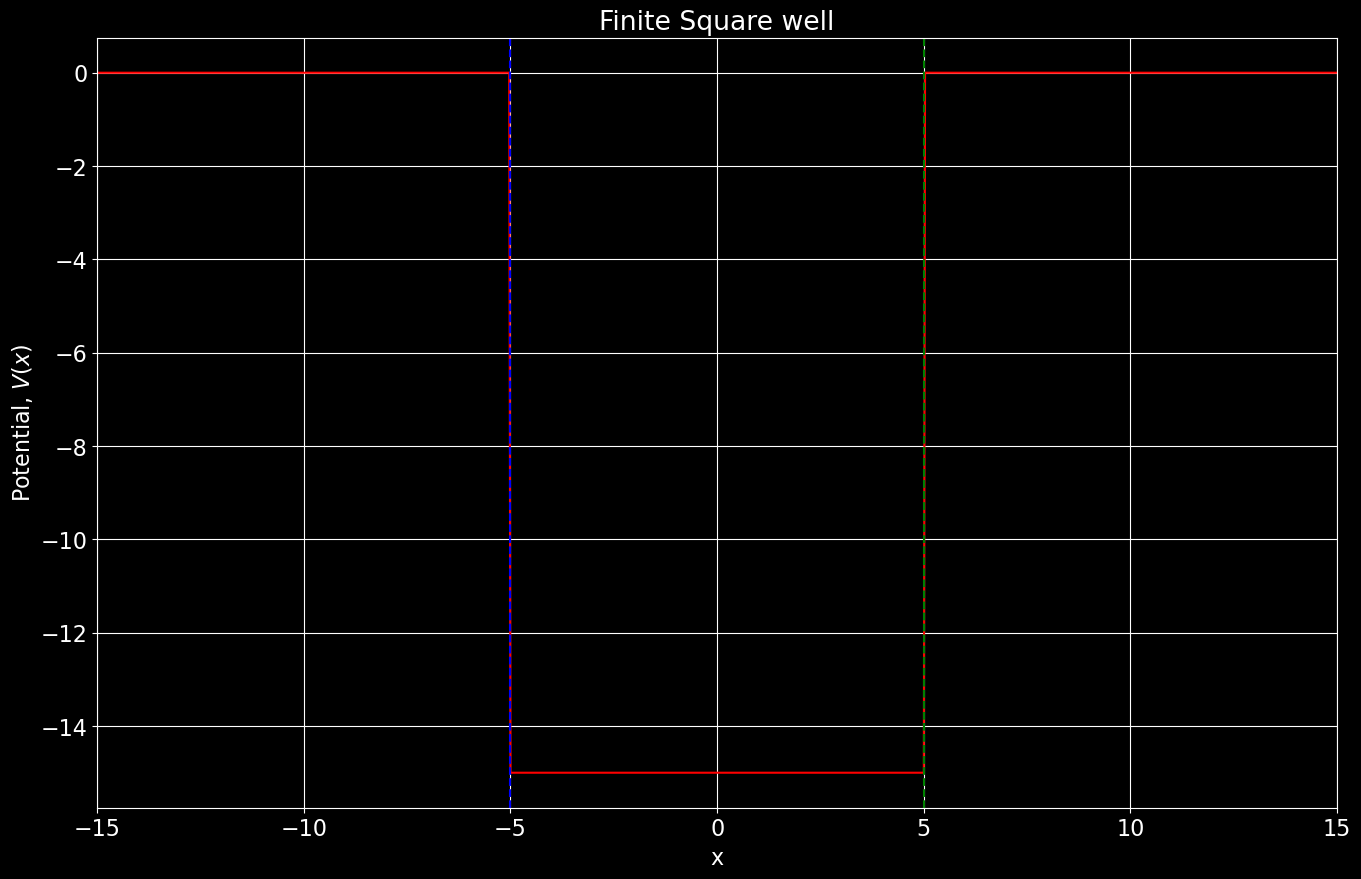

In [2]:
# Boundaries of the well
a = -5 # Left boundary
b = 5 # Right boundary
h_0 = - 15 # The depth of the well
h_1 = 0 # The height of the well

# defining the potential well (symmetric)
def pot_well (x, a, b):
    return np.piecewise(x, [x < a, (x >= a) & (x <= b), x > b], [h_1, h_0, h_1])

# Calculate the midpoint of the well
mid = (a + b) / 2

# Define x such that the midpoint of the well is at the center
x = np.linspace(mid - 3 * np.abs(a) , mid + 3 * np.abs(b), 1000)

plt.plot(x, pot_well(x, a, b), color = 'red')
plt.axvline(x = a, color = 'blue', linestyle = '--', label = f'Left Boundary, x = {a}')
plt.axvline(x = b, color = 'green', linestyle = '--', label = f'Right Boundary, x = {b}')
plt.title('Finite Square well')
plt.xlabel('x')
plt.xlim(mid - 3 * np.abs(a), mid + 3 * np.abs(b))
plt.ylabel('Potential, $V(x)$')
#plt.ylim(h_0, np.abs(h_0))
#plt.legend()
#plt.tight_layout()
plt.show()

For the region $x<-a=-5$ and $x>b=5$, where $E-V\left(x\right)<0$, the Schrodinger equation will read:
\begin{aligned} \psi''\left(x\right)=\frac{2m}{\hbar^2}\left[E-V\left(x\right)\right]\psi\left(x\right) \end{aligned}

With its solution being:
\begin{aligned}\psi_1(x)&=Ae^{\frac{\sqrt{2m\left(V\left(x\right)-E\right)}}{\hbar} x}, &&x<-a\\
\psi_3(x)&=Ae^{-\frac{\sqrt{2m\left(V\left(x\right)-E\right)}}{\hbar} x}, &&x>b\\
\end{aligned}

For the middle region, we have the solution $\psi_2\left(x\right)=A\sin{(kx)}+B\cos{(kx)}, -a<x<b$.

Combining the solutions:
\begin{aligned}\psi\left(x\right)=\begin{cases}\psi_1(x)&=Ae^{\frac{\sqrt{2m\left(V\left(x\right)-E\right)}}{\hbar} x}, &&x<-a\\
\psi_2\left(x\right)&=A\sin{(kx)}+B\cos{(kx)}, &&-a<x<b \\
\psi_3(x)&=Ae^{-\frac{\sqrt{2m\left(V\left(x\right)-E\right)}}{\hbar} x}, &&x>b\end{cases}
\end{aligned}

The factor that determines our splitting of section is by looking at when will $E-V\left(x\right)$ be zero, which we will call the turning points. For example, our first turning point is $-a$ and $b$ will therefore be the 2nd turning point. This can also be observed by the number of points that our specified value of $E$ that will intersect the potential.

However, when we are not capable of solving a potential analytically, we can implement numerical methods. Here we introduce the Numerov Method, which is an iteration method that gives error of 6th order $O\left(\delta x^6\right)$:

We have the Schrodinger Equation:
\begin{aligned}\psi''\left(x\right)+\frac{2m}{\hbar^2}\left[E-V\left(x\right)\right]\psi\left(x\right)&=0 \\
\psi''\left(x\right)&=-k^2\left(x\right)\psi\left(x\right)
\end{aligned}

where we absorbed $\begin{aligned} \frac{2m}{\hbar^2}\end{aligned}\left[E-V\left(x\right)\right]$ into $k^2\left(x\right)$.

It should be noted that $E\ge V_0$ for the function to be normalised.

Discretising the variable, $x$, and applying the three point finite difference to approximate the second derivative:
\begin{aligned}\psi''\left(x\right)\approx\frac{\psi\left(x_{i+1}\right)-2\psi\left(x_{i}\right)+\psi\left(x_{i-1}\right)}{h^2}-\frac{h^2}{12}\psi^{\left(4\right)}\left(x\right)\end{aligned}

To improve our order of accuracy, we differentiate the Schrodinger Equation two more times, and substituting back in the finite difference formula:
\begin{aligned}\psi^{\left(4\right)}\left(x\right)=-\left(k^2\left(x\right)\psi\left(x\right)\right)'' \end{aligned}

From there, we obtain:
\begin{aligned}\psi''\left(x\right)\approx\frac{\psi\left(x_{i+1}\right)-2\psi\left(x_{i}\right)+\psi\left(x_{i-1}\right)}{h^2}+\frac{k^2\left(x_{i+1}\right)\psi\left(x_{i+1}\right)-2k^2\left(x_{i}\right)\psi\left(x_{i}\right)+k^2\left(x_{i-1}\right)\psi\left(x_{i-1}\right)}{12}\end{aligned}

Isolating the $\psi\left(x_{i+1}\right)$ term:
\begin{aligned}\psi\left(x_{i+1}\right)=\frac{\psi\left(x_{i}\right)\left(2+\frac{5}{6}h^2k^2\left(x_{i}\right)\right)-\psi\left(x_{i-1}\right)\left(1-\frac{1}{12}h^2k^2\left(x_{i-1}\right)\right)}{1-\frac{1}{12}h^2k^2\left(x_{i+1}\right)} \end{aligned}

For the iteration from the right, we isolate the $\psi\left(x_{i-1}\right)$ term:
\begin{aligned}\psi\left(x_{i-1}\right)=\frac{\psi\left(x_{i}\right)\left(2+\frac{5}{6}h^2k^2\left(x_{i}\right)\right)-\psi\left(x_{i+1}\right)\left(1-\frac{1}{12}h^2k^2\left(x_{i+1}\right)\right)}{1-\frac{1}{12}h^2k^2\left(x_{i-1}\right)} \end{aligned}

*Well, there's also a trick of iterating from the right (by reversing the initial and final points for np.linspace) which I will not be implementing here.*

Therefore, from the iteration formula, we require the first two points of the wavefunction. Fortunately, we can just set an arbitrary point, effectively far away from the region of the potential, and set it to be zero.

For the second point, we can just put an arbitrarily small number (say, $1\times 10^{-10}$) and iterate from there.

Apart from the continuity of the values of the functions at the turning points, we need to consider the continuity of the gradient for the iterations from both sides. If the chosen eigenvalue is correct, there should be no difference in the values of the function obtained at the turning points.

For the functions, the continuity conditions are:
\begin{aligned} \psi_l\left(x_r\right) &= \psi_r\left(x_r\right) 
\\
\psi_l'\left(x_r\right) &= \psi_r'\left(x_r\right)
\end{aligned}

Dividing the two equations, and applying the three point formula for the first derivative of $\psi$:
\begin{aligned} \frac{\left[\psi_l\left(x_r+h\right)-\psi_l\left(x_r-h\right)\right]-\left[\psi_r\left(x_r+h\right)-\psi_r\left(x_r-h\right)\right]}{2h\psi\left(x_r\right)}=0 \end{aligned}

Therefore, we would like to find out what values of $E$ that will satisfy the above equation. If you haven't noticed, this is a root finding problem, which we can easily apply root-finding algorithms or built in functions.

We shall set the equation as $f\left(E\right)$, since we are only changing the value of $E$ and obtaining the value of the result (which is the difference in the iteration at a certain point). Again, if we have the correct value of $E$, the function must be zero.

\begin{aligned} f\left(E\right)=\frac{\left[\psi_l\left(x_r+h\right)-\psi_l\left(x_r-h\right)\right]-\left[\psi_r\left(x_r+h\right)-\psi_r\left(x_r-h\right)\right]}{2h\psi\left(x_r\right)}=0 \end{aligned}

Now, we consider the following potential well, with a particle bound in it:

\begin{aligned}V\left(x\right)=\frac{\hbar^2}{2m}\alpha^2\lambda\left(\lambda-1\right)\left[\frac 1 2-\frac{1}{\cosh^2{\left(\alpha x\right)}}\right]\end{aligned}

where $\alpha$ and $\lambda$ are given parameters.
The graph with $\alpha=1$ and $\lambda=4$ is as shown:

Plugging in the parameters:

In [3]:
hbar = 1
m = 1
alpha = 2
lambda1 = 4
#omega = 1 #Testing for harmonic oscillator, if the reader wishes to test

# Main definition of Potential
def V(x):
    return hbar ** 2 / (2 * m) * (alpha ** 2) * lambda1 * (lambda1 - 1) * (0.5 - 1 / (np.cosh(alpha * x)) ** 2)
    #return 0.5 * m * omega ** 2 * x ** 2 #Testing for harmonic oscillator, if the reader wishes to test

Plotting of the potential,

The given eigenvalues are in the form:

\begin{aligned}E_n=\frac{\hbar^2}{2m}\alpha^2\left[\frac{\lambda\left(\lambda-1\right)}{2}-\left(\lambda-1-n\right)^2\right], n = 0, 1, 2, 3, \dots \end{aligned}

with the first 10 eigenvalues as shown below:

First, we make a guess for the eigenvalues, $E$ (or just use the actual eigenvalue that we just computed, which i am going to do here):

In [4]:
E_x = 2

The turning point is where $E=V(x)$.

To find the turning point, we use Bisection Method:

Therefore the root is found by bisection method. Note that the trick of multiplying a negative sign on the root we found is only valid for symmetric potentials, mirrored at $x=0$.

For a much simpler method of finding the root, we use the built in fsolve function:

Which proves that the code for Bisection Method is doing its work.

Now we set the boundaries of the plot. We set the leftmost and rightmost boundaries to be effectively far away from the potential. In this code, the boundaries depend on the width of the roots.

We also set the values of the wavefunction at the two endpoints to be zero, as a starting point.

The roots are our turning points. Based on the value of the roots,  we plot for the intersection of $V=E$ and $V=V\left(x\right)$:

Checking the values of the graph (Remove the #print(df)):

Now it's time for us to iterate the function. First, we iterate from the left boundary to the first turning point, checking the values of the wavefunction along the way:

Also iterating from the right boundary to the second turning point:

From the above, we see that the values of graphs around the turning points are symmetric to each other. That is a good sign that our iteration is correct.

Plotting from left boundary, to the second turning point; and from right boundary, to the first turning point (This is to check the overlapping for the oscillatory region):

As shown above, at the right energy values, the shooting from the left overlaps with the shooting from the right exactly. This is where we understand why only certain $E$ values are accepted. At values other than the eigenvalues, the wavefunction will not decay to zero on both sides of the turning point.

As a proof to the statement above, let us try, for $E=1.0V$:

As shown above, the wavefunction is not tame at regions outside the well, they are exponentially increasing. This is always the case for the wrong values of $E$.

Now, we iterate the function below to find the exact value of E:

\begin{aligned} f\left(E\right)=\frac{\left[\psi_l\left(x_r+h\right)-\psi_l\left(x_r-h\right)\right]-\left[\psi_r\left(x_r+h\right)-\psi_r\left(x_r-h\right)\right]}{2h\psi\left(x_r\right)}=0 \end{aligned}

We take the first turning point as our reference.

The code below is a close replica of the entire code above, just that it is combined into a function that depends only on $E$. It is for us to check the values of $f\left(E\right)$, and enable us to iteratively solve for the root of the said function.

As seen from the last few lines, I can only change the values of $E$ and check for the value of the function. In the case for $E=2.5 V$, the value of the function at that point is effectively close to zero, which means that one of the eigenvalues is $2.5 V$.

Having obtained the function of $f\left(E\right)$, we use Bisection Method to iterate the root (selecting a value between $-2.0$ and $0$, since I already know the value is $-1.5V$, just to prove my code):

Which shows us that one of the eigenvalues is $1.5$, equal to the exact expression for $n=0$ (for the exact eigenvalue function we did early on). I hope this code is packed with enough information for you to understand my flow of thoughts, that is it then!